In [1]:
import os 
import pandas as pd
import numpy as np


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt


In [2]:
!pip install pmdarima prophet


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#reading file from local directory
path =r"D:\STUDY\CS550 ML\assignment5\data"
datalist = os.listdir(path)

In [4]:
datalist

['ADANIPORTS.csv',
 'ASIANPAINT.csv',
 'AXISBANK.csv',
 'BAJAJ-AUTO.csv',
 'BAJAJFINSV.csv',
 'BAJFINANCE.csv',
 'BHARTIARTL.csv',
 'BPCL.csv',
 'BRITANNIA.csv',
 'CIPLA.csv',
 'COALINDIA.csv',
 'DRREDDY.csv',
 'EICHERMOT.csv',
 'GAIL.csv',
 'GRASIM.csv',
 'HCLTECH.csv',
 'HDFC.csv',
 'HDFCBANK.csv',
 'HEROMOTOCO.csv',
 'HINDALCO.csv',
 'HINDUNILVR.csv',
 'ICICIBANK.csv',
 'INDUSINDBK.csv',
 'INFRATEL.csv',
 'INFY.csv',
 'IOC.csv',
 'ITC.csv',
 'JSWSTEEL.csv',
 'KOTAKBANK.csv',
 'LT.csv',
 'MARUTI.csv',
 'MM.csv',
 'NESTLEIND.csv',
 'NIFTY50_all.csv',
 'NTPC.csv',
 'ONGC.csv',
 'POWERGRID.csv',
 'RELIANCE.csv',
 'SBIN.csv',
 'SHREECEM.csv',
 'stock_metadata.csv',
 'SUNPHARMA.csv',
 'TATAMOTORS.csv',
 'TATASTEEL.csv',
 'TCS.csv',
 'TECHM.csv',
 'TITAN.csv',
 'ULTRACEMCO.csv',
 'UPL.csv',
 'VEDL.csv',
 'WIPRO.csv',
 'ZEEL.csv']

In [5]:
fpath =  "D:/STUDY/CS550 ML/assignment5/data/SBIN.csv"
fname = fpath.split('/')[-1].split('.')[0].capitalize()

In [6]:
fname

'Sbin'

In [7]:
df = pd.read_csv(fpath)

In [8]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.00000,5.306000e+03,5.306000e+03,2.456000e+03,4.792000e+03,4792.000000
mean,965.871438,967.182115,982.101583,950.898587,965.727026,965.895543,966.77033,1.003930e+07,4.136854e+14,1.507028e+05,3.012573e+06,0.280363
std,857.785547,858.925475,870.739801,845.761231,857.510230,857.766537,858.38307,1.783189e+07,4.578376e+14,1.082755e+05,5.073956e+06,0.120499
min,141.450000,142.850000,147.950000,140.050000,140.550000,141.450000,145.90000,3.633000e+03,7.680600e+10,4.016000e+03,1.548000e+04,0.029400
25%,258.662500,259.262500,262.662500,255.000000,258.500000,258.712500,258.58750,1.451959e+06,1.447402e+14,8.465700e+04,3.537600e+05,0.190900
50%,475.275000,475.050000,482.625000,466.400000,475.000000,475.275000,476.19000,2.580254e+06,3.116596e+14,1.168515e+05,6.799895e+05,0.273800
75%,1722.025000,1725.000000,1755.000000,1695.000000,1718.737500,1722.025000,1725.38750,1.193361e+07,5.085768e+14,1.750568e+05,4.349524e+06,0.362075
max,3489.950000,3505.000000,3515.000000,3451.350000,3499.000000,3489.950000,3485.25000,2.626771e+08,8.549083e+15,1.155236e+06,1.333311e+08,0.948200


In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from pmdarima import auto_arima,arima
import plotly.express as ex

adding new features for better metrics:


Change: The Profit/Close i.e. (Close - Open)

% Change: How much the stock lost or gained during a day

decline: Whether the particular stock declined during the day

the above 3 factors can be very important for the prediciton and better metric

In [10]:
#adding 3 more features change, decline and percent change in the opening and closing of the stock price
df.loc[:,'Change'] = df.loc[:, 'Close'] - df.loc[:,'Open']
df.loc[:, 'Decline'] = (df.loc[:, 'Change']/df.loc[:, 'Open']) < 0
df.loc[:,"% Change"] = df.loc[:, 'Change']/df.loc[:, 'Open']

In [11]:
fig2 = ex.line(df,x='Date',y='% Change',color='Decline',color_discrete_sequence=['red','green'])
fig2.show()

calculating moving averages :

moving averages help us to see the stock prices in a long term by smoothing the graph and shows
the general trend of the graph

In [12]:
# Calculating moving Averages

ndf = df.set_index('Date')
ndf.loc[:,'MA-7'] = ndf.loc[:,'Close'].rolling(7).mean()
ndf.loc[:,'MA-14'] = ndf.loc[:,'Close'].rolling(14).mean()
ndf.loc[:,'MA-60'] = ndf.loc[:,'Close'].rolling(60).mean()
ndf = ndf.reset_index()
ndf.loc[:,'Decline'] = ndf.loc[:,'% Change'] < 0

In [13]:
fig3 = ex.line(ndf,x='Date',y=['Close','MA-7','MA-14','MA-60'],title='Moving Average for week, bi week and 60 days')
fig3.show()

In [14]:
pathNifty50 = 'D:/STUDY/CS550 ML/assignment5/data/NIFTY50_all.csv'
cumlative_df = pd.read_csv(pathNifty50)
cumlative_df.set_index('Date',inplace=True)


In [15]:
#taking similar type of stocks under 1 label
cumlative_df.loc[cumlative_df['Symbol'] == 'MUNDRAPORT','Symbol'] = 'ADANIPORTS'
cumlative_df.loc[cumlative_df['Symbol'] == 'BAJAUTOFIN','Symbol'] = 'BAJFINANCE'
cumlative_df.loc[cumlative_df['Symbol'] == 'HINDALC0','Symbol'] = 'HINDALCO'
cumlative_df.loc[cumlative_df['Symbol'] == 'KOTAKMAH','Symbol'] = 'KOTAKBANK'
cumlative_df.loc[cumlative_df['Symbol'] == 'UTIBANK','Symbol'] = 'AXISBANK'
cumlative_df.loc[cumlative_df['Symbol'] == 'ZEETELE','Symbol'] = 'ZEEL'
cumlative_df.loc[cumlative_df['Symbol'] == 'INFOSYSTCH','Symbol'] = 'INFY'
cumlative_df.loc[cumlative_df['Symbol'] == 'BHARTI','Symbol'] = 'BHARTIARTL'
cumlative_df.loc[cumlative_df['Symbol'] == 'SESAGOA','Symbol'] = 'VEDL'
cumlative_df.loc[cumlative_df['Symbol'] == 'HEROHONDA','Symbol'] = 'HEROMOTOCO'
cumlative_df.loc[cumlative_df['Symbol'] == 'TELCO','Symbol'] = 'TATAMOTORS'
cumlative_df.loc[cumlative_df['Symbol'] == 'TISCO','Symbol'] = 'TATASTEEL'
cumlative_df.loc[cumlative_df['Symbol'] == 'HINDLEVER','Symbol'] = 'HINDUNILVR'
cumlative_df.loc[cumlative_df['Symbol'] == 'JSWSTL','Symbol'] = 'JSWSTEEL'
cumlative_df.loc[cumlative_df['Symbol'] == 'SSLT','Symbol'] = 'VEDL'

In [16]:
#for comparing different stocks w.r.t. days
compartive_df = pd.DataFrame(columns=cumlative_df['Symbol'].unique())
for name in compartive_df.columns:
    compartive_df.loc[:,name] = cumlative_df[cumlative_df['Symbol'] == name]['Close']

In [17]:
cumlative_df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2007-11-27,ADANIPORTS,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619.0,0.3612
2007-11-28,ADANIPORTS,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278.0,0.3172
2007-11-29,ADANIPORTS,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678.0,0.2088
2007-11-30,ADANIPORTS,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913.0,0.2735
2007-12-03,ADANIPORTS,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123.0,0.2741


In [18]:
compartive_df.head()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BHARTIARTL,BPCL,BRITANNIA,CIPLA,...,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,UNIPHOS,UPL,VEDL,WIPRO,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-27,962.90,998.15,932.10,NaN,NaN,317.30,915.85,406.90,1516.45,183.60,...,848.90,995.95,1040.00,1530.50,1000.65,337.10,NaN,3386.95,457.80,299.60
2007-11-28,893.90,1006.45,905.70,NaN,NaN,321.55,910.05,384.50,1482.90,182.85,...,816.60,976.50,1035.45,1471.35,989.10,334.80,NaN,3332.45,449.75,292.75
2007-11-29,884.20,998.10,918.85,NaN,NaN,322.75,914.75,382.30,1493.35,182.00,...,798.25,966.05,986.15,1463.40,976.85,334.10,NaN,3260.70,448.10,281.25
2007-11-30,921.55,990.00,930.65,NaN,NaN,330.35,939.50,386.35,1492.35,183.10,...,825.90,1012.20,1026.70,1534.25,984.25,342.95,NaN,3450.70,460.65,287.90
2007-12-03,969.30,986.60,942.35,NaN,NaN,332.90,923.95,402.85,1468.10,185.25,...,842.20,1049.90,1058.15,1548.65,999.15,344.20,NaN,3500.65,492.10,303.80


For example: Taking TataMotors and TataSteel

My hypothesis is that both stocks are somehow related to each other
Reason: Both are under Tata and Steel is one of major product of Motor vechile's

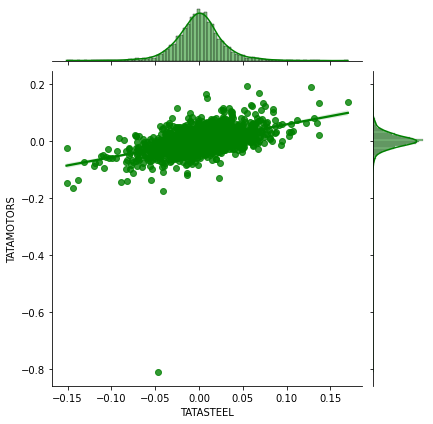

In [19]:
import seaborn as sns
motors = compartive_df[['HEROMOTOCO','EICHERMOT']].pct_change()
tatas = compartive_df[['TATASTEEL','TATAMOTORS']].pct_change()
power = compartive_df[['NTPC','BPCL']].pct_change()
two_banks = compartive_df[['SBIN','HDFCBANK']].pct_change()

sns.jointplot(data=tatas,x='TATASTEEL',y='TATAMOTORS',color='green',kind='reg')

In [20]:
tatas.corr()['TATAMOTORS'][0]

0.4922853000888176

positive correlation between tatamotors and tatasteel

In [21]:
compartive_df.dropna(axis=1,inplace=True)
ndfs = compartive_df.pct_change()

In [22]:
#finding coorelation matrix of the compartive data
fig = ex.imshow(ndfs.corr(), text_auto = True,
color_continuous_scale='rainbow',aspect='auto')
fig.show()

spending Rs10000 at each stock to determine the risk in each.

In [23]:
invest = 10000
risks = []


In [24]:
for name in compartive_df.columns:
    compartive_df.loc[:,name+".Invested"] = (compartive_df.loc[:,name]/compartive_df.loc[compartive_df.index[0],name])*invest
    mid = compartive_df[name+'.Invested'].to_frame().sum(axis=1).pct_change(1)
    risks.append([name.capitalize(),(mid.mean()/mid.std())*(compartive_df.shape[0]**0.5)])
    risks[-1].append(risks[-1][1] > 1)

In [25]:
risk = pd.DataFrame(risks,columns=['Name','Risk','Profit'])
risk.head()

,Name,Risk,Profit
0,Adaniports,0.997647,False
1,Asianpaint,2.108007,True
2,Axisbank,0.997036,False
3,Bhartiartl,0.366845,False
4,Bpcl,0.929171,False


In [26]:
#applying the prophet model
vals = compartive_df.loc[:,'TCS'].reset_index()
vals.columns = ['ds','y']
prp = Prophet(uncertainty_samples=100,n_changepoints=100,seasonality_prior_scale=12.0)
prp.fit(vals)
df = prp.make_future_dataframe(periods=500)
df_no_weekdays = df[df['ds'].dt.dayofweek < 5]
fore = prp.predict(df_no_weekdays)

21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing


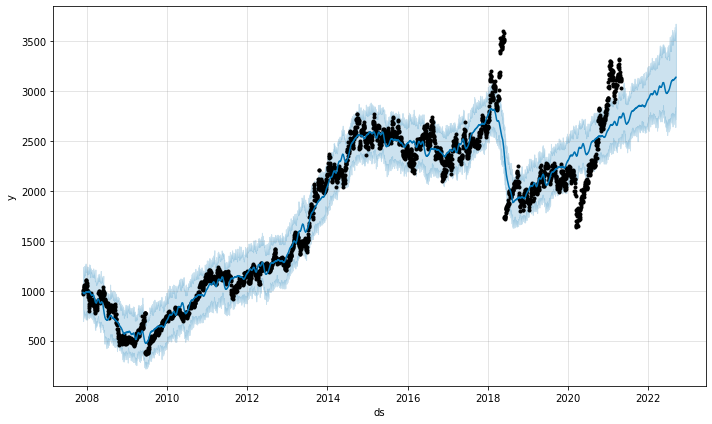

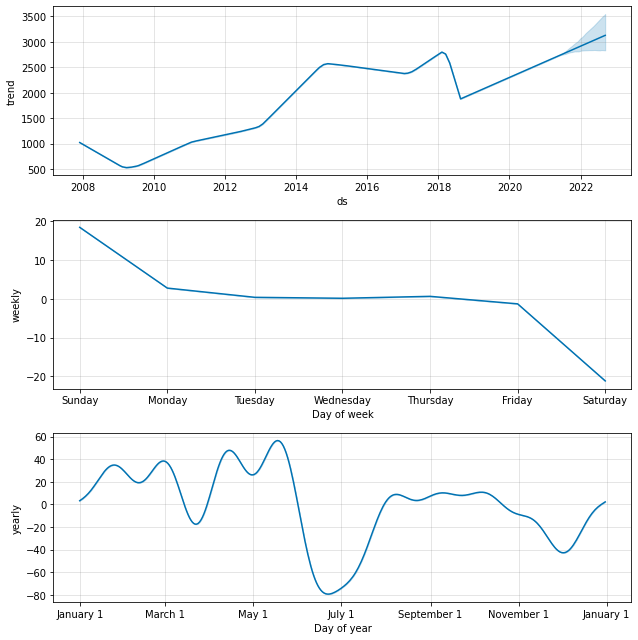

In [27]:
fig = prp.plot(fore)
fig2 = prp.plot_components(fore)
plt.show()

# ARIMA

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima    

In [29]:
df = pd.read_csv("./data/BAJAJFINSV.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


<AxesSubplot:xlabel='Date'>

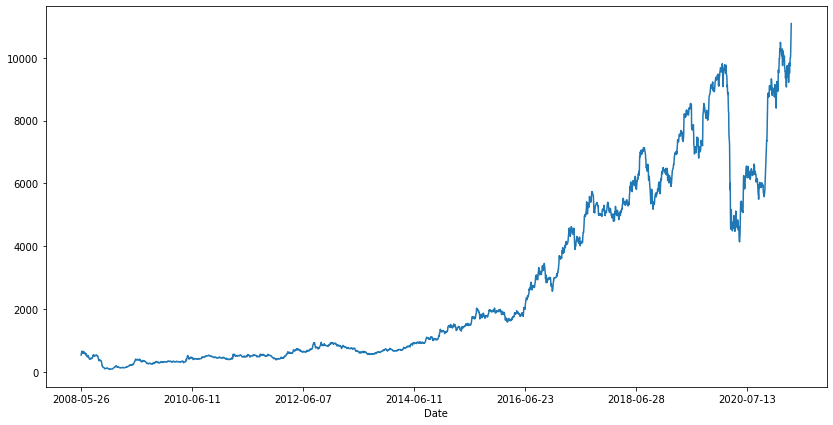

In [30]:
df.VWAP.plot(figsize=(14, 7))

In [31]:
#train_data, test_data = cumlative_df[:int(len(cumlative_df)*0.8)], cumlative_df[int(len(cumlative_df)*0.8):]

In [32]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

C:\Users\siddh\AppData\Local\Temp/ipykernel_2408/2560288566.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888,5,22,26,0
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558,5,22,27,1
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689,5,22,28,2
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225,5,22,29,3
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514,5,22,30,4


In [33]:
#creating other dataframes for rolling window of 3days, 7days and 30days
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

#adding these features to our original dataframe.
for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()


C:\Users\siddh\AppData\Local\Temp/ipykernel_2408/1668882315.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

C:\Users\siddh\AppData\Local\Temp/ipykernel_2408/1668882315.py:28: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,...,9.306703e+13,3.202323e+13,4.039685e+13,5.419115e+13,20805.792969,20746.582031,20480.119141,6680.793945,8337.476562,10924.103516
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,...,1.726368e+14,3.202323e+13,4.039685e+13,5.419115e+13,20805.792969,20746.582031,20480.119141,6680.793945,8337.476562,10924.103516
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,...,2.107369e+14,5.388164e+13,5.388164e+13,5.388164e+13,20805.792969,20746.582031,20480.119141,6680.793945,8337.476562,10924.103516
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,...,2.350756e+14,5.682195e+13,5.682195e+13,5.682195e+13,20805.792969,20746.582031,20480.119141,6680.793945,8337.476562,10924.103516
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,...,2.508797e+14,2.541759e+13,5.613884e+13,5.613884e+13,20805.792969,20746.582031,20480.119141,6680.793945,8337.476562,10924.103516


In [34]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

In [35]:
#list of new features that we created above.
exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

In [36]:
#training the arima model
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=29826.074, Time=5.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=29811.894, Time=3.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=29683.277, Time=3.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30130.953, Time=4.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47844.587, Time=4.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29792.127, Time=4.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29883.575, Time=4.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=29821.493, Time=4.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29680.559, Time=3.81 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29790.376, Time=4.32 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=29881.465, Time=3.68 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=30128.816, Time=3.87 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29819.682, Time=3.95 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 53.186 seconds


c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\siddh\AppData\Local\Temp/ipykernel_2408/2175841875.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='Date'>

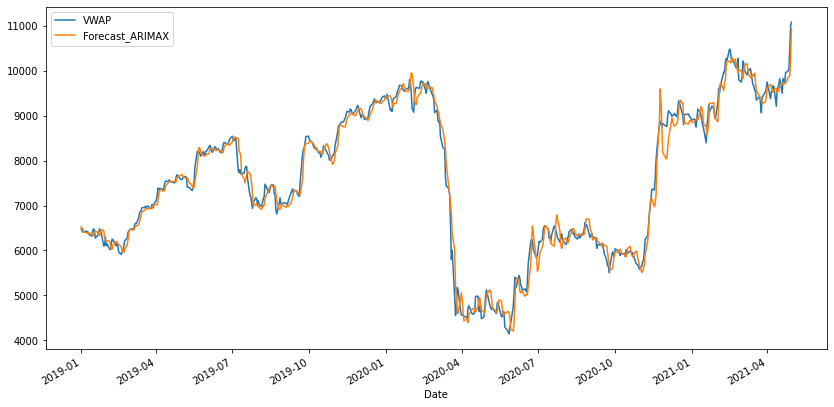

In [37]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

# RRN

<AxesSubplot:>

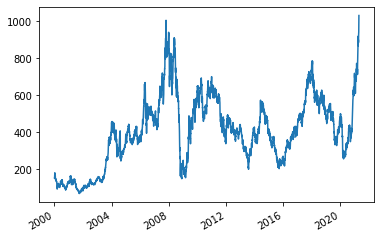

In [38]:
stock_name = 'TATASTEEL'

df = pd.read_csv('data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

In [39]:
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat
    

In [40]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [41]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)

(5255, 50) (5255, 1)


In [42]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 

In [43]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(5000, 50, 1) (255, 50, 1) (5000, 1) (255, 1)


In [44]:
def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model1 = create_model1()

In [45]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = 300, batch_size = 16, callbacks=[ early_stop])

Epoch 1/300
313/313 [==============================] - 3s 6ms/step - loss: 0.0114 - val_loss: 0.0069
Epoch 2/300
313/313 [==============================] - 2s 6ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 3/300
313/313 [==============================] - 2s 5ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 4/300
313/313 [==============================] - 2s 5ms/step - loss: 8.2993e-04 - val_loss: 0.0017
Epoch 5/300
313/313 [==============================] - 2s 5ms/step - loss: 6.5867e-04 - val_loss: 0.0015
Epoch 6/300
313/313 [==============================] - 2s 5ms/step - loss: 5.2159e-04 - val_loss: 0.0011
Epoch 7/300
313/313 [==============================] - 2s 5ms/step - loss: 4.5152e-04 - val_loss: 8.2006e-04
Epoch 8/300
313/313 [==============================] - 2s 5ms/step - loss: 3.9561e-04 - val_loss: 6.3654e-04
Epoch 9/300
313/313 [==============================] - 2s 5ms/step - loss: 3.5488e-04 - val_loss: 6.9834e-04
Epoch 10/300
313/313 [==============================] -

In [46]:
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)

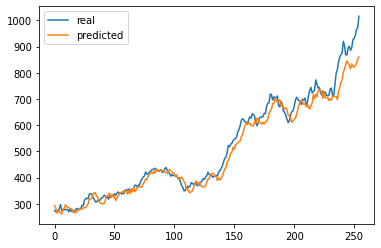

In [47]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [48]:
def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [49]:
def rmse_func(x,y):
    
    return np.round( np.sqrt(mse(x,y)) ,4)

In [50]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = 300, batch_size = 16, callbacks=[ early_stop])

y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)



Epoch 1/300
313/313 [==============================] - 4s 11ms/step - loss: 0.0113 - val_loss: 0.0014
Epoch 2/300
313/313 [==============================] - 3s 11ms/step - loss: 6.9312e-04 - val_loss: 9.9669e-04
Epoch 3/300
313/313 [==============================] - 3s 11ms/step - loss: 4.8854e-04 - val_loss: 7.3744e-04
Epoch 4/300
313/313 [==============================] - 3s 11ms/step - loss: 3.9344e-04 - val_loss: 5.3552e-04
Epoch 5/300
313/313 [==============================] - 3s 10ms/step - loss: 3.1999e-04 - val_loss: 4.8588e-04
Epoch 6/300
313/313 [==============================] - 3s 11ms/step - loss: 2.8196e-04 - val_loss: 4.1932e-04
Epoch 7/300
313/313 [==============================] - 3s 10ms/step - loss: 2.7230e-04 - val_loss: 3.1331e-04
Epoch 8/300
313/313 [==============================] - 3s 10ms/step - loss: 2.5375e-04 - val_loss: 2.8937e-04
Epoch 9/300
313/313 [==============================] - 3s 11ms/step - loss: 2.3267e-04 - val_loss: 2.7810e-04
Epoch 10/300
313/3

In [51]:
print('RMSE+:',rmse_func(y_pred2,scaler.inverse_transform(yvalid)))

RMSE+: 19.7396


# LSTM

In [52]:
def create_model5(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model5 = create_model5(out_dim = look_ahead)
model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 10)          480       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [53]:
model5.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = 300, batch_size = 16, callbacks=[ early_stop])

y_pred5 = model5.predict(xvalid)
y_pred5 = scaler.inverse_transform(y_pred5)

Epoch 1/300
313/313 [==============================] - 10s 23ms/step - loss: 0.0126 - val_loss: 0.0054
Epoch 2/300
313/313 [==============================] - 7s 21ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 3/300
313/313 [==============================] - 6s 19ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 4/300
313/313 [==============================] - 6s 20ms/step - loss: 8.1051e-04 - val_loss: 0.0014
Epoch 5/300
313/313 [==============================] - 6s 19ms/step - loss: 6.6662e-04 - val_loss: 8.1613e-04
Epoch 6/300
313/313 [==============================] - 7s 21ms/step - loss: 5.4756e-04 - val_loss: 0.0013
Epoch 7/300
313/313 [==============================] - 7s 21ms/step - loss: 4.9714e-04 - val_loss: 8.8408e-04
Epoch 8/300
313/313 [==============================] - 7s 22ms/step - loss: 4.5534e-04 - val_loss: 0.0011
Epoch 9/300
313/313 [==============================] - 7s 22ms/step - loss: 4.1926e-04 - val_loss: 5.5473e-04
Epoch 10/300
313/313 [=======================

In [54]:
print('RMSE: ' + str(rmse_func(y_pred5, scaler.inverse_transform(yvalid))))

RMSE: 27.5389


model15:LSTM
model2:RNN
prp: prophet
model : auto-arima


# analysis


In [55]:
!pip install yfinance


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
import yfinance as yf

start_date = '2021-07-23'
end_date = '2022-07-29'

# Get the data
data_hdfc = yf.download('HDFC.NS', start_date, end_date)
data_tata = yf.download('TATAMOTORS.NS',start_date, end_date)
data_aapl = yf.download('AAPL',start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [57]:
data_hdfc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-23,2497.800049,2501.600098,2470.000000,2482.500000,2451.039307,1275979
2021-07-26,2485.000000,2485.000000,2460.000000,2464.300049,2433.070068,1462225
2021-07-27,2470.899902,2474.000000,2430.000000,2433.949951,2403.104492,2680260
2021-07-28,2417.100098,2432.449951,2380.000000,2425.800049,2395.057861,3988878
2021-07-29,2424.000000,2433.649902,2405.100098,2414.800049,2384.197266,3288676


In [58]:
data_tata.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-23,300.500000,301.899994,295.000000,295.549988,295.549988,33435130
2021-07-26,295.000000,297.000000,291.000000,293.149994,293.149994,27502360
2021-07-27,293.000000,297.649994,288.600006,291.399994,291.399994,55132877
2021-07-28,290.000000,290.899994,283.600006,284.450012,284.450012,36139725
2021-07-29,287.549988,295.399994,287.549988,292.899994,292.899994,57733359


In [59]:
data_aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-23,147.550003,148.720001,146.919998,148.559998,147.266861,71447400
2021-07-26,148.270004,149.830002,147.699997,148.990005,147.693146,72434100
2021-07-27,149.119995,149.210007,145.550003,146.770004,145.492462,104818600
2021-07-28,144.809998,146.970001,142.539993,144.979996,143.718018,118931200
2021-07-29,144.690002,146.550003,144.580002,145.639999,144.372269,56699500


In [60]:
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

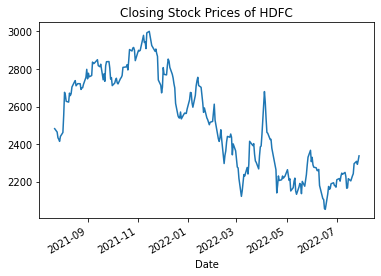

In [61]:
data_hdfc['Close'].plot()

plt.title('Closing Stock Prices of HDFC')
plt.show()

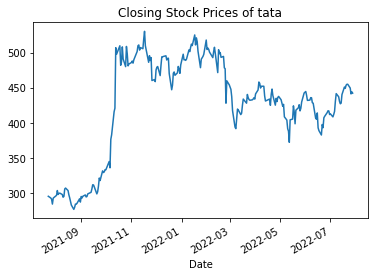

In [62]:
data_tata['Close'].plot()

plt.title('Closing Stock Prices of tata')
plt.show()

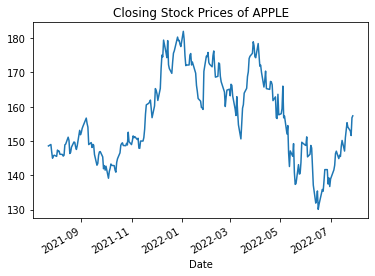

In [63]:
data_aapl['Close'].plot()

plt.title('Closing Stock Prices of APPLE')
plt.show()

as per the record the ukraine war started on 24th feb,2022 and is still going on.

we take 3 datasets for our analysis, datasets of APPLE, HDFC and TATAMOTORS.

In [64]:
!pip install --upgrade ta
from ta import add_all_ta_features
from ta.utils import dropna


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### TATA

In [93]:
ti_data = add_all_ta_features(data_tata, open='Open', high='High', low='Low', close='Close', volume='Volume')

c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:780: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:785: RuntimeWarning:

invalid value encountered in double_scalars



Average directional movement (ADX)

ADX ≤ 25: No trend

25 < ADX ≤ 50: Trending

ADX > 50: Strong Trending

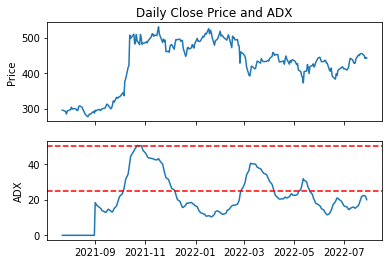

In [94]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(data_tata['Close'])
ax2.set_ylabel('ADX')
ax2.plot(ti_data['trend_adx'])
ax1.set_title('Daily Close Price and ADX')
ax2.axhline(y = 50, color = 'r', linestyle = '--')
ax2.axhline(y = 25, color = 'r', linestyle = '--')
plt.show()

we can see that in the start of 2022 hdfc stock pricing has been decreasing and had a gradual decrease till june 2022, we  can see a slight rise in the stock pricing at the end of  june to july,2022.
the ADX values has beel below 25 for almost all the time since 2022-02 showing no trending of these stocks.

Relative Strength Index (RSI)

RSI > 70: Overbought

RSI < 30: Oversold

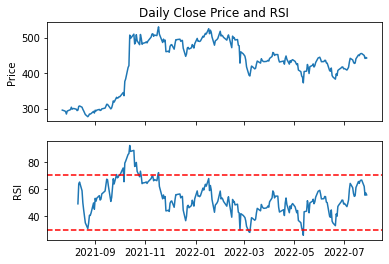

In [81]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(data_tata['Close'])
ax2.set_ylabel('RSI')
ax2.plot(ti_data['momentum_rsi'])
ax1.set_title('Daily Close Price and RSI')
ax2.axhline(y = 70, color = 'r', linestyle = '--')
ax2.axhline(y = 30, color = 'r', linestyle = '--')
plt.show()

value at risk

In [91]:
data_tata['returns'] = data_tata['Close'].pct_change()

In [92]:
import scipy
returns = data_tata['returns'].dropna()
mean = returns.mean()
sigma = returns.std()
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.04491798365298538

Text(0, 0.5, 'Close')

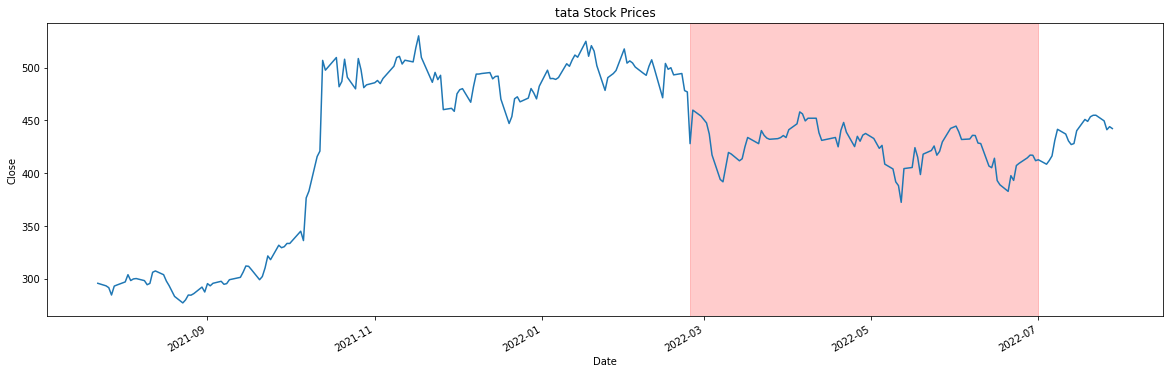

In [111]:
ax = data_tata['Close'].plot(figsize=(20,6))
ax.set_title('tata Stock Prices')
ax.axvspan('2022-02-24','2022-07-01', color='red', alpha=0.2) # Modi Govt

ax.set_ylabel('Close')

here we can see a sharp but slight decrease at the begining of the Ukrain war,but the newest trend is showing a steady rize in the stock value

In [99]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string(), '\n')          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

adf_test(data_tata['Close'],title='Reliance Stock Data');

Augmented Dickey-Fuller Test: Reliance Stock Data
ADF test statistic       -2.104339
p-value                   0.242773
# lags used               4.000000
# observations          249.000000
critical value (1%)      -3.456888
critical value (5%)      -2.873219
critical value (10%)     -2.572994 

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



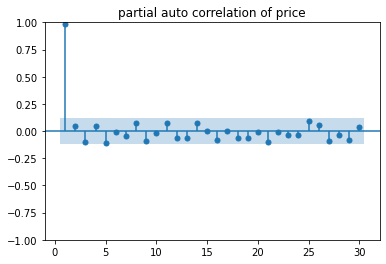

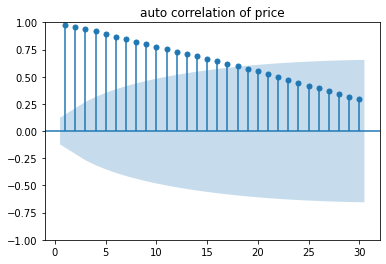

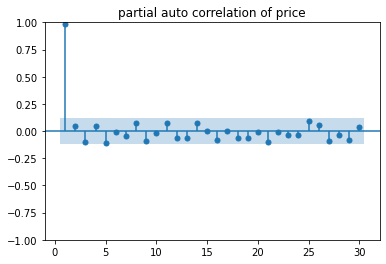

In [110]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(data_tata['Close'], lags=30,title='auto correlation of price',zero=False);
sm.graphics.tsa.plot_pacf(data_tata['Close'], lags=30,title='partial auto correlation of price',zero=False)

### HDFC

In [104]:
ti_data = add_all_ta_features(data_hdfc, open='Open', high='High', low='Low', close='Close', volume='Volume')

c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:780: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:785: RuntimeWarning:

invalid value encountered in double_scalars



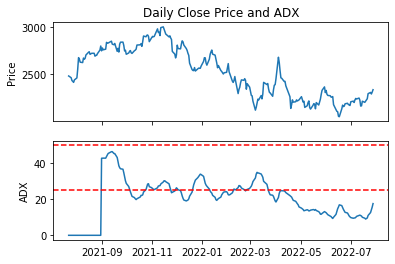

In [105]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(data_hdfc['Close'])
ax2.set_ylabel('ADX')
ax2.plot(ti_data['trend_adx'])
ax1.set_title('Daily Close Price and ADX')
ax2.axhline(y = 50, color = 'r', linestyle = '--')
ax2.axhline(y = 25, color = 'r', linestyle = '--')
plt.show()

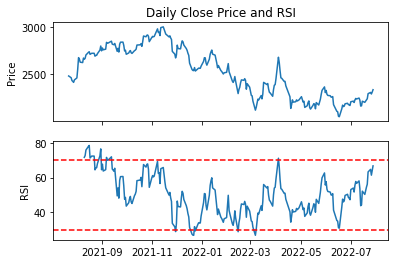

In [106]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(data_hdfc['Close'])
ax2.set_ylabel('RSI')
ax2.plot(ti_data['momentum_rsi'])
ax1.set_title('Daily Close Price and RSI')
ax2.axhline(y = 70, color = 'r', linestyle = '--')
ax2.axhline(y = 30, color = 'r', linestyle = '--')
plt.show()

In [107]:
data_hdfc['returns'] = data_hdfc['Close'].pct_change()

In [108]:
import scipy
returns = data_hdfc['returns'].dropna()
mean = returns.mean()
sigma = returns.std()
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.0295700735157412

Text(0, 0.5, 'Close')

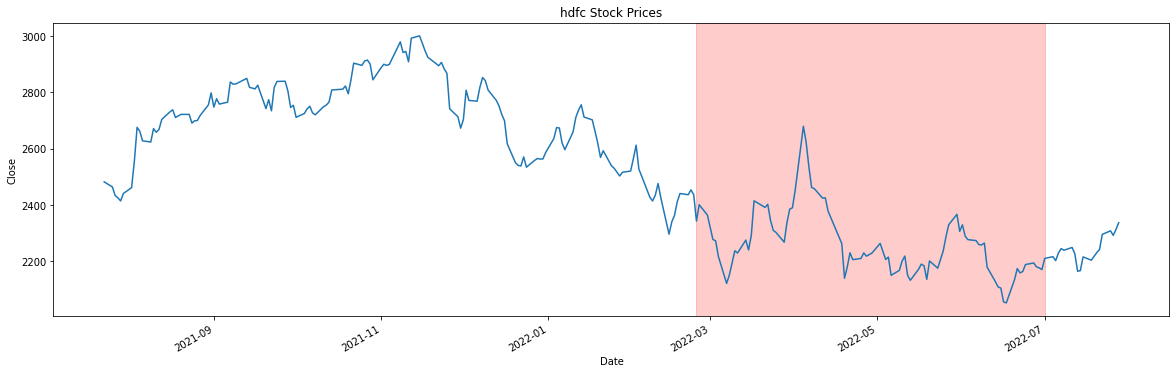

In [109]:
ax = data_hdfc['Close'].plot(figsize=(20,6))
ax.set_title('hdfc Stock Prices')
ax.axvspan('2022-02-24','2022-07-01', color='red', alpha=0.2) # Modi Govt

ax.set_ylabel('Close')

there was a sudden decrease in the stock pricing at the exact date of the beginning of Ukraine war. and after that the prices ahve been low till present time as well.

In [72]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string(), '\n')          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

adf_test(data_hdfc['Close'],title='Reliance Stock Data');

Augmented Dickey-Fuller Test: Reliance Stock Data
ADF test statistic       -1.502973
p-value                   0.532040
# lags used               1.000000
# observations          252.000000
critical value (1%)      -3.456569
critical value (5%)      -2.873079
critical value (10%)     -2.572919 

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


plot acf and pacf

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



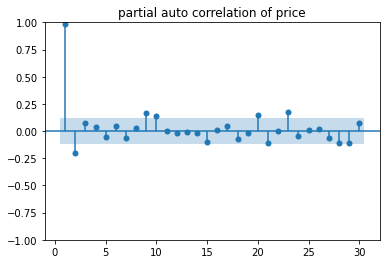

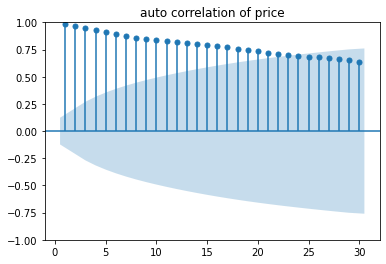

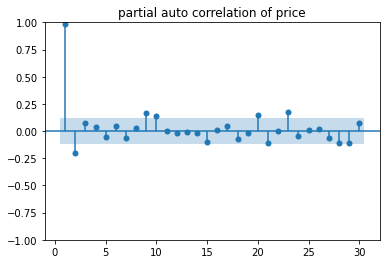

In [74]:
#plt.rcParams.update({'figure.figsize': (20,6)})

sm.graphics.tsa.plot_acf(data_hdfc['Close'], lags=30,title='auto correlation of price',zero=False);
sm.graphics.tsa.plot_pacf(data_hdfc['Close'], lags=30,title='partial auto correlation of price',zero=False)